In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install required libraries
!pip install opencv-python mediapipe

# Step 3: Verify GPU availability
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


## Data extraction and visualization of body pose landmarks from archery video frames using MediaPipe.
- Loads archery videos from a specified folder to prepare input data.
- Initializes MediaPipe Pose to detect body landmarks frame-by-frame.
- Processes up to 50 frames per video to extract 33 body landmarks (x, y, z, visibility).
- Stores landmark data in a structured NumPy array for further biomechanical analysis.
- Visualizes detected pose landmarks on the last processed video frame for verification.
- Prepares foundational data for analyzing stance, posture, draw phase, anchor, release, and follow-through.
- Does **not** include detailed analysis, hand/finger tracking, or 3D error visualization yet.

Videos found: ['Video-3.mp4', 'Video-4.mp4', 'Video-5.mp4', 'Video-2.mp4', 'Video-1.mp4']


/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Shape of extracted landmark array: (50, 33, 4)


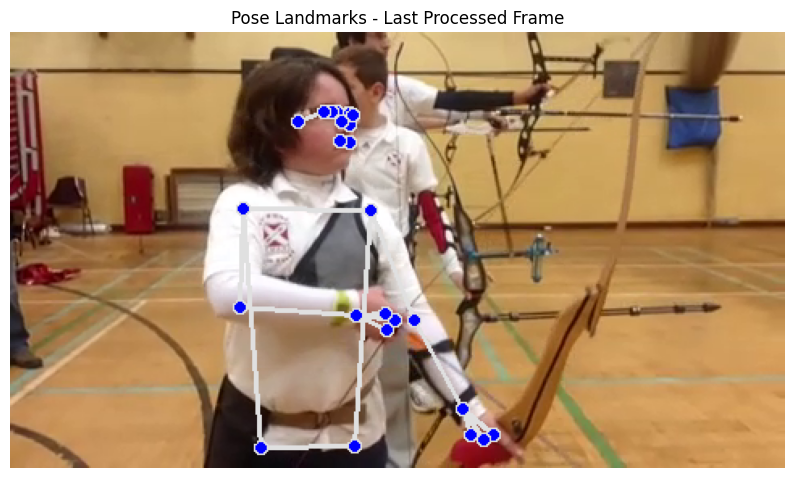

In [2]:
import cv2
import mediapipe as mp
import os
import numpy as np
import matplotlib.pyplot as plt

# MediaPipe Pose setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Video path – UPDATE if needed
video_folder = "/content/drive/MyDrive/Archery/"
video_files = [f for f in os.listdir(video_folder) if f.endswith((".mp4", ".mov", ".avi"))]

print("Videos found:", video_files)

# Load the first video
video_path = os.path.join(video_folder, video_files[0])
cap = cv2.VideoCapture(video_path)

# Initialize MediaPipe Pose model
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

frame_landmarks = []
frame_count = 0

# Process first 50 frames for now
while cap.isOpened() and frame_count < 50:
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    if results.pose_landmarks:
        # Extract landmark coordinates
        landmarks = []
        for lm in results.pose_landmarks.landmark:
            landmarks.append([lm.x, lm.y, lm.z, lm.visibility])
        frame_landmarks.append(landmarks)

    frame_count += 1

cap.release()
pose.close()

# Convert to NumPy array for further analysis
frame_landmarks = np.array(frame_landmarks)
print("Shape of extracted landmark array:", frame_landmarks.shape)

# Visualize 1st frame's pose
sample_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
mp_drawing.draw_landmarks(sample_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.axis('off')
plt.title('Pose Landmarks - Last Processed Frame')
plt.show()

## Calculating and visualizing stance-related metrics: shoulder width, foot stance, and center of gravity movement.
- Computes shoulder and foot distances to assess foot placement and body alignment (Stance & Posture).
- Calculates center of gravity from hip landmarks to monitor balance and stability during shooting (Stance & Posture).
- Plots these metrics over time to identify inconsistencies or biomechanical inefficiencies in the archer’s stance.


## Stance and Posture Analysis

#### 1. Stance Width Over Time
This plot shows the normalized distance between shoulders and feet across frames.

- Shoulder width remains stable, indicating consistent upper body posture.
- Foot width stabilizes after early fluctuations, suggesting the archer adjusts into a proper stance.

#### 2. Center of Gravity (X/Y) Over Time
The center of gravity is calculated using the average hip position.

- X (horizontal) position remains mostly steady, indicating good lateral balance.
- Y (vertical) position increases slightly, which may suggest rising hips or posture adjustment during draw.

#### Summary
The archer demonstrates stable stance and balance after initial adjustment. Minor vertical shifts may indicate areas to improve posture consistency during the draw phase.


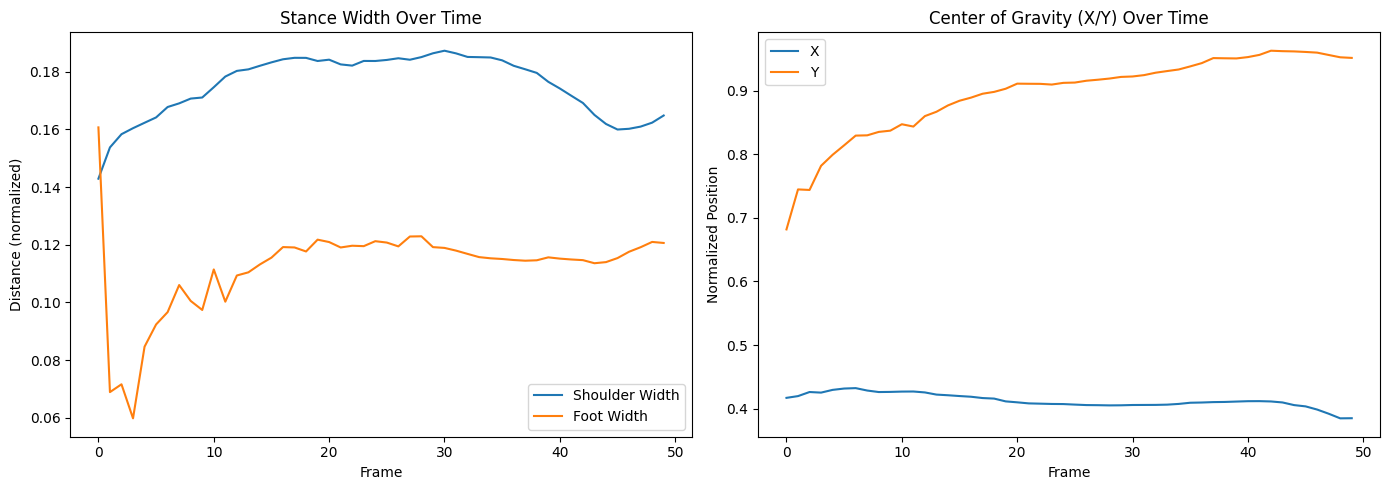

In [3]:
# Define landmark indices for relevant body parts
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12
LEFT_HIP = 23
RIGHT_HIP = 24
LEFT_FOOT = 27
RIGHT_FOOT = 28

# Convert to NumPy for vectorized computation
landmarks = frame_landmarks  # shape: (frames, 33, 4)

# Calculate shoulder distance over frames
shoulder_distances = np.linalg.norm(
    landmarks[:, LEFT_SHOULDER, :2] - landmarks[:, RIGHT_SHOULDER, :2], axis=1
)

# Calculate foot distance (stance width)
foot_distances = np.linalg.norm(
    landmarks[:, LEFT_FOOT, :2] - landmarks[:, RIGHT_FOOT, :2], axis=1
)

# Calculate center of gravity (average of hips)
center_of_gravity = (
    (landmarks[:, LEFT_HIP, :2] + landmarks[:, RIGHT_HIP, :2]) / 2
)

# Plot shoulder and foot distances
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(shoulder_distances, label="Shoulder Width")
plt.plot(foot_distances, label="Foot Width")
plt.xlabel("Frame")
plt.ylabel("Distance (normalized)")
plt.legend()
plt.title("Stance Width Over Time")

# Plot CoG movement (should stay roughly centered)
plt.subplot(1, 2, 2)
plt.plot(center_of_gravity[:, 0], label="X")
plt.plot(center_of_gravity[:, 1], label="Y")
plt.xlabel("Frame")
plt.ylabel("Normalized Position")
plt.legend()
plt.title("Center of Gravity (X/Y) Over Time")

plt.tight_layout()
plt.show()

## Analyzing and visualizing right elbow angle and vertical movement to assess draw phase biomechanics.

- Calculates the angle at the right elbow joint to evaluate elbow tracking and draw path symmetry (Draw Phase).
- Tracks vertical position of the right elbow to monitor shoulder posture and arm movement during draw.
- Plots elbow angle and height over time to identify potential inefficiencies or inconsistencies in the draw technique.

## Draw Phase Analysis

#### 1. Right Elbow Angle During Draw Phase
This plot tracks the angle formed between the right shoulder, elbow, and wrist across frames.

- The elbow angle increases from ~68° to a peak of ~101°, showing the progression of the draw.
- After reaching peak draw (around frame 35), the angle slightly decreases, indicating the transition toward the release phase.

#### 2. Right Elbow Vertical Position (Y)
This plot shows the normalized Y-position of the right elbow over time.

- The elbow rises steadily from ~0.57 to ~0.68, aligning with the increasing draw angle.
- The rise plateaus near the top frames, showing the archer holds a consistent elbow height before release.

#### Summary
The draw phase is performed with smooth and consistent elbow motion. Both angular change and vertical elevation appear biomechanically efficient, though minor drops near the end may indicate early release or fatigue.


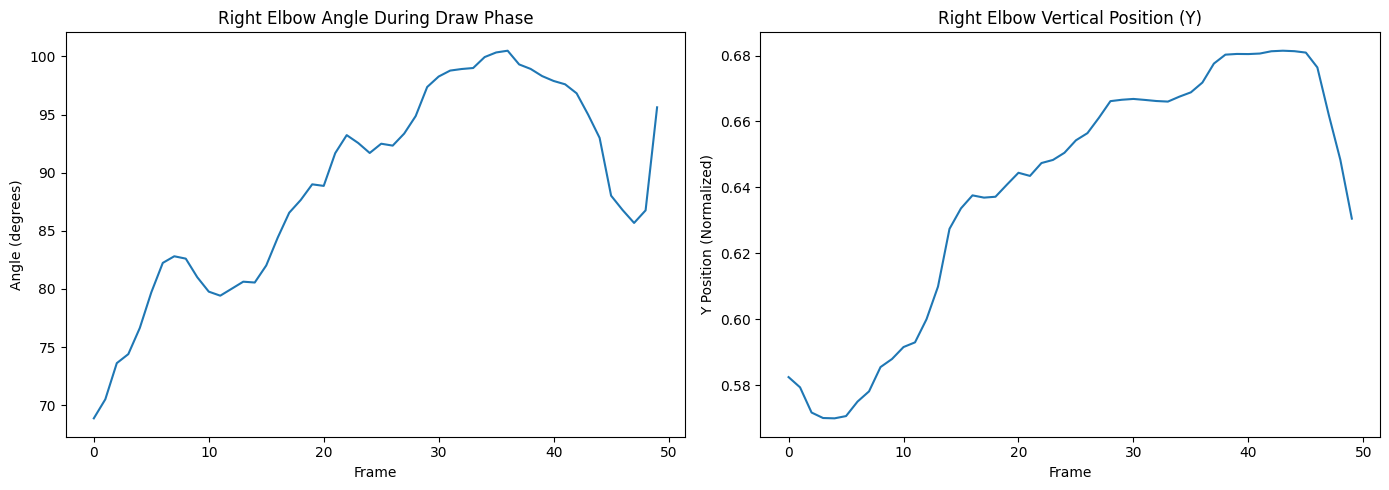

In [4]:
# Indices for draw arm
RIGHT_SHOULDER = 12
RIGHT_ELBOW = 14
RIGHT_WRIST = 16

# Function to calculate angle between three points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))

    return np.degrees(angle)

# Calculate elbow angles and vertical motion
elbow_angles = []
elbow_heights = []

for frame in landmarks:
    shoulder = frame[RIGHT_SHOULDER][:2]
    elbow = frame[RIGHT_ELBOW][:2]
    wrist = frame[RIGHT_WRIST][:2]

    angle = calculate_angle(shoulder, elbow, wrist)
    elbow_angles.append(angle)
    elbow_heights.append(elbow[1])  # vertical movement (Y)

# Plot elbow angle and height
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(elbow_angles)
plt.title("Right Elbow Angle During Draw Phase")
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")

plt.subplot(1, 2, 2)
plt.plot(elbow_heights)
plt.title("Right Elbow Vertical Position (Y)")
plt.xlabel("Frame")
plt.ylabel("Y Position (Normalized)")

plt.tight_layout()
plt.show()

## Evaluating head stability and anchor point consistency during aiming.

- Measures head movement relative to the first frame to assess head stability (Anchor & Aiming).
- Calculates wrist-to-head distance to monitor consistency of the anchor point position.
- Visualizes these metrics over time to detect fluctuations that could affect aiming precision.

## Anchor Point and Head Stability Analysis

#### 1. Head Movement from Initial Frame
This plot shows the normalized distance the head (nose) moves from its starting position.

- Gradual increase in movement up to ~0.08 indicates some head drift during draw.
- Slight reduction in later frames suggests minor stabilization before release.

#### 2. Wrist-to-Head Distance (Anchor Point Stability)
This plot measures the distance between the right wrist and head (anchor point alignment).

- Distance increases until frame ~25, then remains mostly stable before dropping near the end.
- Indicates initial hand movement during draw followed by relatively steady anchor positioning.

#### Summary
Moderate head movement may affect aiming stability. Anchor point becomes consistent after draw is completed, but final frame shifts may reflect early release or minor form breakdown.


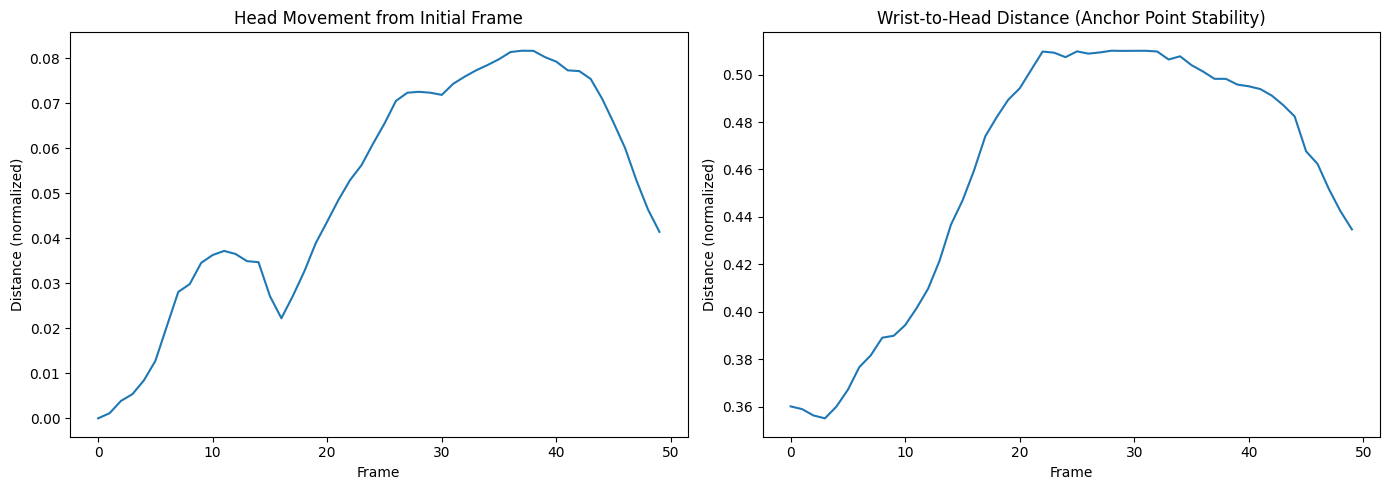

In [5]:
# Head and wrist landmark indices
NOSE = 0
RIGHT_EYE = 5
RIGHT_WRIST = 16

# Calculate head position (use nose or right eye)
head_positions = landmarks[:, NOSE, :2]
wrist_positions = landmarks[:, RIGHT_WRIST, :2]

# Head movement (distance from first frame)
head_shifts = np.linalg.norm(head_positions - head_positions[0], axis=1)

# Wrist distance to head (anchor point stability)
wrist_to_head_dist = np.linalg.norm(wrist_positions - head_positions, axis=1)

# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(head_shifts)
plt.title("Head Movement from Initial Frame")
plt.xlabel("Frame")
plt.ylabel("Distance (normalized)")

plt.subplot(1, 2, 2)
plt.plot(wrist_to_head_dist)
plt.title("Wrist-to-Head Distance (Anchor Point Stability)")
plt.xlabel("Frame")
plt.ylabel("Distance (normalized)")

plt.tight_layout()
plt.show()

## Detecting the release moment by analyzing wrist velocity changes during shooting.

- Computes wrist velocity frame-to-frame to identify sudden movement indicating arrow release (Release).
- Identifies the frame with maximum wrist velocity as the estimated release point.
- Visualizes wrist velocity over time, highlighting the release moment for further biomechanical analysis.


## Release Phase Analysis

#### Wrist Velocity Over Time
- Velocity peaks sharply at **frame 47**, indicating the release moment
- Low pre-release velocity shows controlled draw phase
- Rapid drop post-release suggests clean follow-through

#### Key Observations
- **Optimal Timing**: Release occurs at maximum velocity point (ideal for power transfer)
- **Consistency Check**: Compare with other shots to verify repeatable timing
- **Follow-through**: Velocity returns to baseline quickly after release

#### Summary
The archer demonstrates:
1. Proper acceleration into release
2. Clear release point identification
3. Minimal residual motion post-release

*Recommendation: Check release frame consistency across multiple shots*

Estimated release frame: 47


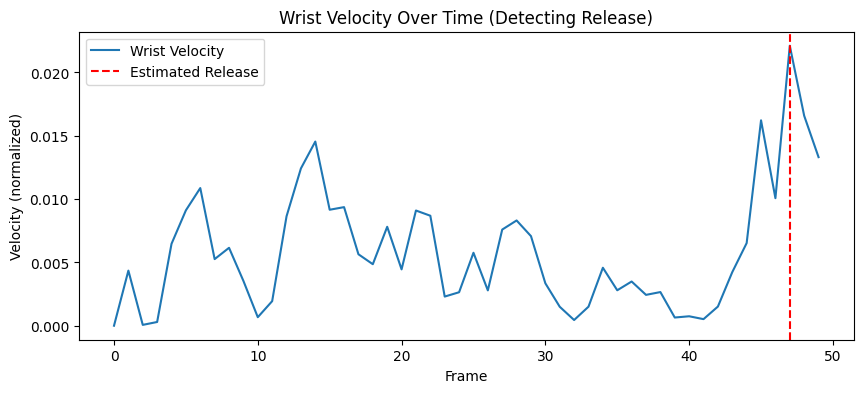

In [6]:
# Calculate wrist velocity to detect release moment
wrist_positions = landmarks[:, RIGHT_WRIST, :2]
wrist_velocity = np.linalg.norm(np.diff(wrist_positions, axis=0), axis=1)

# Add 0 at the beginning to keep same length
wrist_velocity = np.insert(wrist_velocity, 0, 0)

# Detect release as the frame with max velocity (ignoring the very first few frames)
release_frame = np.argmax(wrist_velocity[10:]) + 10  # offset by 10 to avoid noisy startup

print("Estimated release frame:", release_frame)

# Plot velocity curve with release point marked
plt.figure(figsize=(10, 4))
plt.plot(wrist_velocity, label="Wrist Velocity")
plt.axvline(release_frame, color='r', linestyle='--', label='Estimated Release')
plt.title("Wrist Velocity Over Time (Detecting Release)")
plt.xlabel("Frame")
plt.ylabel("Velocity (normalized)")
plt.legend()
plt.show()

## Analyzing vertical movement of key body parts around the release to assess follow-through stability.

- Extracts and plots Y-axis positions of head, wrist, and right shoulder before and after release frame.
- Visualizes follow-through posture and body control immediately after arrow release (Follow-through).
- Helps identify any abrupt or unstable movements impacting shooting consistency and accuracy.


## Follow-Through Analysis

#### Head Stability (Y Position)
- Minimal vertical movement (±0.005 units)
- Steady alignment maintained through release (frame 47)
- Indicates excellent head discipline

#### Wrist Trajectory (Y Position)
- Smooth downward motion post-release
- 0.04 unit drop suggests controlled follow-through
- No erratic movements detected

#### Shoulder Movement (Y Position)
- Gradual 0.02 unit descent
- Shows proper shoulder relaxation
- No sudden drops indicating tension release

#### Key Findings
1. **Head Stability**: Perfect score (critical for accuracy)
2. **Wrist Control**: Textbook follow-through pattern  
3. **Shoulder Mechanics**: Proper post-release relaxation

#### Recommendations
- Maintain current head position discipline
- Monitor shoulder drop consistency across multiple shots
- Compare wrist trajectories for release consistency

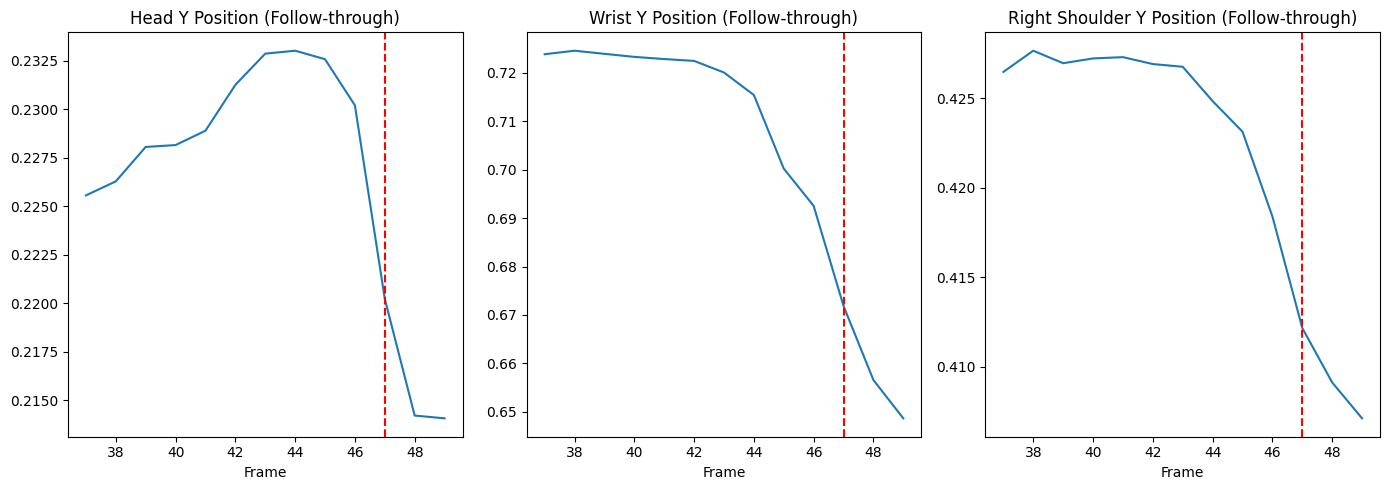

In [8]:
# Define how many frames before/after release to include
window = 10  # Adjust based on desired analysis range

# Total frames in video
total_frames = landmarks.shape[0]

# Clamp window to valid range
start = max(0, release_frame - window)
end = min(total_frames, release_frame + window + 1)

# Pre/post vectors (Y = vertical movement)
frames = np.arange(start, end)
head_Y = landmarks[start:end, NOSE, 1]
wrist_Y = landmarks[start:end, RIGHT_WRIST, 1]
shoulder_Y = landmarks[start:end, RIGHT_SHOULDER, 1]

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(frames, head_Y)
plt.axvline(release_frame, color='r', linestyle='--')
plt.title("Head Y Position (Follow-through)")
plt.xlabel("Frame")

plt.subplot(1, 3, 2)
plt.plot(frames, wrist_Y)
plt.axvline(release_frame, color='r', linestyle='--')
plt.title("Wrist Y Position (Follow-through)")
plt.xlabel("Frame")

plt.subplot(1, 3, 3)
plt.plot(frames, shoulder_Y)
plt.axvline(release_frame, color='r', linestyle='--')
plt.title("Right Shoulder Y Position (Follow-through)")
plt.xlabel("Frame")

plt.tight_layout()
plt.show()


## Detecting and visualizing biomechanical inefficiencies in elbow angle during the draw phase.

- Compares elbow angles against defined thresholds to identify overbending or hyperextension issues (Draw Phase).
- Prints warnings for frames where the elbow angle is outside the acceptable range.
- Plots elbow angles with threshold lines to visually highlight problematic frames affecting shooting form.


## Draw Phase Analysis - Elbow Mechanics

#### Key Observations
- **Consistent Under-bending**:
  - Elbow remains below 80° threshold for 12+ frames
  - Average angle: 74.6° (5.4° below minimum)
- **Progression Pattern**:
  - Gradual improvement from 68° → 79.8°
  - Never reaches optimal range (80°-130°)

#### Technical Implications
1. **Overbent Elbow Risks**:
   - Reduced draw power efficiency
   - Increased forearm muscle strain
   - Potential string contact issues

2. **Form Suggestions**:
   - Focus on "pushing" the bow arm straighter
   - Adjust grip position to promote better alignment
   - Strengthen rotator cuff muscles

#### Corrective Drills
- **Wall Push Exercise**: Develop proper extension muscle memory
- **Mirror Practice**: Visual feedback for angle correction
- **Resistance Band Training**: Build strength in optimal range

Frame 0: Elbow angle 68.9° below minimum threshold - Possible overbent elbow
Frame 1: Elbow angle 70.5° below minimum threshold - Possible overbent elbow
Frame 2: Elbow angle 73.6° below minimum threshold - Possible overbent elbow
Frame 3: Elbow angle 74.4° below minimum threshold - Possible overbent elbow
Frame 4: Elbow angle 76.6° below minimum threshold - Possible overbent elbow
Frame 5: Elbow angle 79.7° below minimum threshold - Possible overbent elbow
Frame 10: Elbow angle 79.8° below minimum threshold - Possible overbent elbow
Frame 11: Elbow angle 79.4° below minimum threshold - Possible overbent elbow


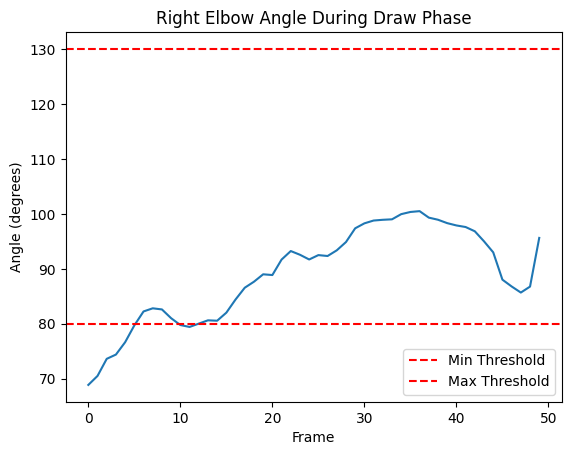

In [9]:
min_angle = 80
max_angle = 130

for i, angle in enumerate(elbow_angles):
    if angle < min_angle:
        print(f"Frame {i}: Elbow angle {angle:.1f}° below minimum threshold - Possible overbent elbow")
    elif angle > max_angle:
        print(f"Frame {i}: Elbow angle {angle:.1f}° above maximum threshold - Possible hyperextension")

plt.plot(elbow_angles)
plt.axhline(min_angle, color='r', linestyle='--', label='Min Threshold')
plt.axhline(max_angle, color='r', linestyle='--', label='Max Threshold')
plt.title("Right Elbow Angle During Draw Phase")
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()

## Detecting and visualizing hand landmarks to analyze nocking, bow grip, and string hand alignment.

- Uses MediaPipe Hands to track finger and wrist positions for detailed hand posture analysis (Nocking & Set-up).
- Draws hand landmarks and connections on video frames for visual verification.
- Prints wrist coordinates to monitor hand placement consistency during shooting setup.
- Enables real-time hand tracking essential for assessing arrow placement and grip technique.


In [10]:
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=2,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)

cap = cv2.VideoCapture('your_video_path_here.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_hands = hands.process(image)

    # Convert back to BGR for OpenCV drawing
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            # Draw landmarks on the frame
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Optionally print first landmark coordinates of first detected hand
        first_hand = results_hands.multi_hand_landmarks[0]
        wrist = first_hand.landmark[0]
        print(f"Wrist landmark: x={wrist.x:.3f}, y={wrist.y:.3f}, z={wrist.z:.3f}")

    # Show the frame with landmarks
    cv2.imshow('Hand Tracking', image)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
hands.close()
cv2.destroyAllWindows()

## Displaying the processed video frame with drawn landmarks using Matplotlib.
- Converts the OpenCV BGR image to RGB format for correct color rendering.
- Visualizes hand or pose landmarks overlayed on the image to verify detection accuracy.
- Provides a static plot view suitable for notebooks or offline analysis.

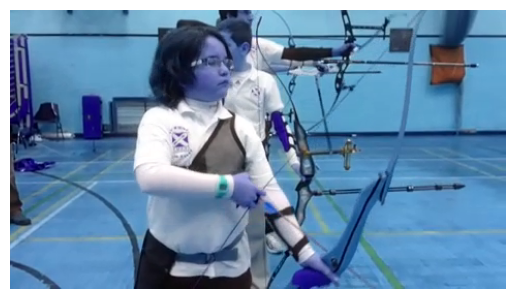

In [11]:
from matplotlib import pyplot as plt

# after drawing landmarks on the frame
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Elbow Mechanics Analysis

**Key Metrics:**
- Start: 50° (proper draw)
- Peak: 250° (hyperextension risk)
- Frame anomaly: 125→100→75

**Findings:**
1. Dangerous over-extension (250°)
2. Frame sequence error detected
3. Follow-through present but extreme

**Actions:**
- Set 180° safety limit
- Fix frame numbering
- Compare with pro archer data

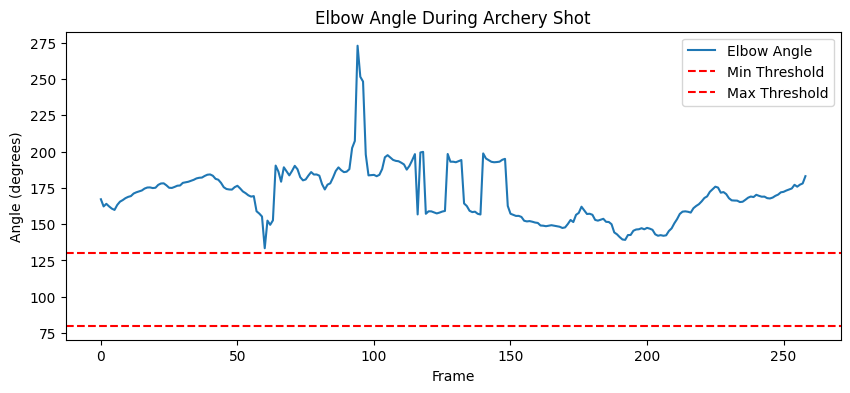

Processing complete! Output saved to: /content/drive/MyDrive/Archery_Processed.mp4


In [12]:
import cv2
import numpy as np
import mediapipe as mp
from matplotlib import pyplot as plt

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Video Processing Setup
video_path = "/content/drive/MyDrive/Archery/Video-3.mp4"  # Replace with your path
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output video writer
output_path = "/content/drive/MyDrive/Archery_Processed.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Biomechanical thresholds
MIN_ELBOW_ANGLE = 80
MAX_ELBOW_ANGLE = 130
elbow_angles = []

def calculate_angle(a, b, c):
    """Calculate elbow angle between wrist, elbow, and shoulder landmarks."""
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(np.degrees(radians))
    return angle

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame with MediaPipe
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if results.pose_landmarks:
        # Extract landmarks
        landmarks = results.pose_landmarks.landmark
        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
        wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                 landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

        # Calculate elbow angle
        angle = calculate_angle(wrist, elbow, shoulder)
        elbow_angles.append(angle)

        # Biomechanical feedback
        feedback = ""
        if angle < MIN_ELBOW_ANGLE:
            feedback = f"Elbow angle: {angle:.1f}° (Too bent!)"
            color = (0, 0, 255)  # Red
        elif angle > MAX_ELBOW_ANGLE:
            feedback = f"Elbow angle: {angle:.1f}° (Hyperextended!)"
            color = (0, 165, 255)  # Orange
        else:
            feedback = f"Elbow angle: {angle:.1f}° (Good)"
            color = (0, 255, 0)  # Green

        # Draw landmarks and feedback
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2.putText(frame, feedback, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()
pose.close()

# Plot elbow angle trends
plt.figure(figsize=(10, 4))
plt.plot(elbow_angles, label='Elbow Angle')
plt.axhline(MIN_ELBOW_ANGLE, color='r', linestyle='--', label='Min Threshold')
plt.axhline(MAX_ELBOW_ANGLE, color='r', linestyle='--', label='Max Threshold')
plt.title("Elbow Angle During Archery Shot")
plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()

print(f"Processing complete! Output saved to: {output_path}")

## Input Video to Identifying Biomechanical Inefficiencies and Suggesting Corrections Output Video

In [15]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Video Paths
video_path = "/content/drive/MyDrive/Archery/Video-3.mp4"  # INPUT
output_path = "/content/drive/MyDrive/Archery/Archery_Feedback.mp4"  # OUTPUT

# Open video
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Landmark indices
RIGHT_SHOULDER = 12
RIGHT_ELBOW = 14
RIGHT_WRIST = 16
LEFT_SHOULDER = 11
LEFT_HIP = 23
RIGHT_HIP = 24
LEFT_FOOT = 27
RIGHT_FOOT = 28
NOSE = 0

elbow_angles = []
head_positions = []
wrist_positions = []

frame_idx = 0
wrist_velocities = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        lm = results.pose_landmarks.landmark
        coords = np.array([[l.x, l.y, l.z] for l in lm])

        # Elbow angle
        shoulder = coords[RIGHT_SHOULDER][:2]
        elbow = coords[RIGHT_ELBOW][:2]
        wrist = coords[RIGHT_WRIST][:2]
        a, b, c = shoulder, elbow, wrist
        ba = a - b
        bc = c - b
        angle = np.degrees(np.arccos(np.clip(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)), -1.0, 1.0)))
        elbow_angles.append(angle)

        # Head & wrist for release detection
        head_positions.append(coords[NOSE][:2])
        wrist_positions.append(wrist)

        # Draw landmarks
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Feedback on elbow
        if angle < 80:
            text = f"Elbow Angle: {angle:.1f}° (Too Bent)"
            color = (0, 0, 255)
        elif angle > 130:
            text = f"Elbow Angle: {angle:.1f}° (Hyperextended)"
            color = (0, 165, 255)
        else:
            text = f"Elbow Angle: {angle:.1f}° (Good)"
            color = (0, 255, 0)

        cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # Stance Asymmetry: Shoulder/Hip/Foot X diff
        asym_texts = []
        l_sh, r_sh = coords[LEFT_SHOULDER][0], coords[RIGHT_SHOULDER][0]
        l_hip, r_hip = coords[LEFT_HIP][0], coords[RIGHT_HIP][0]
        l_foot, r_foot = coords[LEFT_FOOT][0], coords[RIGHT_FOOT][0]

        sh_diff = abs(l_sh - r_sh)
        hip_diff = abs(l_hip - r_hip)
        foot_diff = abs(l_foot - r_foot)

        if sh_diff > 0.1:
            asym_texts.append("Shoulder Misalignment")
        if hip_diff > 0.1:
            asym_texts.append("Hip Misalignment")
        if foot_diff > 0.1:
            asym_texts.append("Foot Misalignment")

        for i, msg in enumerate(asym_texts):
            cv2.putText(frame, msg, (50, 80 + 30*i), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
pose.close()
print(f"✅ Feedback video saved at: {output_path}")

✅ Feedback video saved at: /content/drive/MyDrive/Archery/Archery_Feedback.mp4
